In [1]:
!pip install xgboost
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.1/47.1 kB 3.8 MB/s eta 0:00:00


In [2]:
# General-purpose imports
import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import process_time

# NLTK for text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Gensim for word embeddings
import gensim.downloader as api

# Scikit-learn for machine learning and evaluation
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Perceptron
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier

# External libraries for boosting
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# Library for most common words
from collections import Counter


In [3]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()

Kaggle credentials set.
Kaggle credentials successfully validated.


In [4]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

sub_event_detection_in_twitter_streams_path = kagglehub.competition_download('sub-event-detection-in-twitter-streams')

print('Data source import complete.')

100%|██████████| 174M/174M [00:02<00:00, 78.6MB/s]

Extracting files...


Data source import complete.


In [5]:
# NLTK for text preprocessing
nltk.download('stopwords') # Download stopwords data
nltk.download('wordnet') # Download wordnet data

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [6]:
# Load GloVe model with Gensim's API
embeddings_model = api.load("glove-twitter-200")  # 200-dimensional GloVe embeddings

[==================================================] 100.0% 758.5/758.5MB downloaded


In [7]:
# Read all training files and concatenate them into one dataframe
li = []
for filename in os.listdir('/root/.cache/kagglehub/competitions/sub-event-detection-in-twitter-streams/challenge_data/train_tweets'):
    df = pd.read_csv("/root/.cache/kagglehub/competitions/sub-event-detection-in-twitter-streams/challenge_data/train_tweets/" + filename)
    li.append(df)
df = pd.concat(li, ignore_index=True)

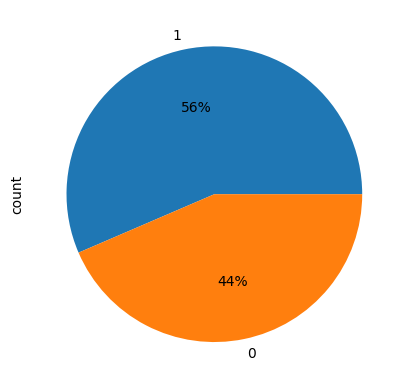

In [8]:
#Evaluate class imbalance
df['EventType'].value_counts().plot(kind='pie', autopct='%1.0f%%')
plt.show()

In [9]:
#Drop the same rows
df = df.drop_duplicates().reset_index(drop=True)

In [10]:
# Function to compute the average word vector for a tweet
def get_avg_embedding(tweet, model, vector_size):
    words = tweet.split()  # Tokenize by whitespace
    word_vectors = [model[word] for word in words if word in model]
    if not word_vectors:  # If no words in the tweet are in the vocabulary, return a zero vector
        return np.zeros(vector_size)
    return np.mean(word_vectors, axis=0)

In [11]:
contractions_dict = {
    "worldcup": "world cup",
    "worldcup2014": "world cup",
    "worldcup2018": "world cup",
    "fifa": "fifa world cup",
    "ger": "germany",
    "bra": "brazil",
    "arg": "argentina",
    "fra": "france",
    "usa": "united states",
    "por": "portugal",
    "bel": "belgium",
    "alg": "algeria",
    "gha": "ghana",
    "ned": "netherlands",
    "chi": "chile",
    "mex": "mexico",
    "aus": "australia",
    "esp": "spain",
    "cmr": "cameroon",
    "nga": "nigeria"
}

In [12]:
def expand_contractions(text, contractions=contractions_dict):
    # Replace contractions with their expanded form using word boundaries
    for contraction, expanded in contractions.items():
        text = re.sub(rf'\b{re.escape(contraction)}\b', expanded, text)
    return text

In [13]:
# Function to preprocess text data
def preprocess_text(text):
    """
    Preprocesses text by performing the following:
    1. Removes retweet indicators and user mentions.
    2. Converts text to lowercase.
    3. Removes punctuation, numbers, and URLs.
    4. Expands contractions.
    5. Tokenizes text into words.
    6. Removes stopwords.
    7. Lemmatizes words to their base forms.
    8. Removes duplicate words.
    9. Returns the cleaned and preprocessed text as a string.
    """

    # Step 1: Remove "RT @username: " for retweets
    text = re.sub(r'^RT @\w+: ', '', text)

    # Step 2: Convert text to lowercase for consistency
    text = text.lower()

    # Step 3: Remove mentions (@username)
    text = re.sub(r'@\w+', '', text)

    # Step 4: Remove punctuation (keep only letters and spaces)
    text = re.sub(r'[^\w\s]', '', text)

    # Step 5: Remove numbers (optional based on your use case)
    text = re.sub(r'\d+', '', text)

    # Step 6: Remove URLs (both http and www formats)
    text = re.sub(r'http\S+|www.\S+', '', text)

    # Step 7: Expand contractions (e.g., "ger" to "germany")
    text = expand_contractions(text)

    # Step 8: Tokenize text into individual words
    words = text.split()

    # Step 9: Remove stopwords (common words like "and", "the", etc.)
    stop_words = set(stopwords.words('english'))  # Load NLTK's English stopword list
    words = [word for word in words if word not in stop_words]

    # Step 10: Lemmatize words to reduce them to their base forms
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Step 11: Remove duplicate words (optional but can reduce redundancy)
    words = list(dict.fromkeys(words))

    # Return the cleaned and preprocessed text as a single string
    return ' '.join(words)


In [14]:
df

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,1_0,1,0,0,1404849000000,RT @RMadridHome: Sami Khedira is starting for ...
1,1_0,1,0,0,1404849000000,RT @Yohanyx3: Damn half of ya saying go brazil...
2,1_0,1,0,0,1404849000000,Colombia should be the ones playing against Ge...
3,1_0,1,0,0,1404849000000,RT @tonyrizk_963: The Injury list :\nFrom #BRA...
4,1_0,1,0,0,1404849000000,Brazil should still be favored vs. Germany—if ...
...,...,...,...,...,...,...
4638238,19_129,19,129,1,1403560800000,RT @Troll__Football: World Cup 2014 so far: \n...
4638239,19_129,19,129,1,1403560800000,So far 6 teams from the 8 who qualified to the...
4638240,19_129,19,129,1,1403560800000,FINAL GROUP A STANDINGS:\n#BRA 7 pts (+5 GD)\n...
4638241,19_129,19,129,1,1403560800000,RT @PurelyFootball: World Cup 2014 so far: \n\...


In [15]:
# Apply preprocessing to each tweet
df['Tweet'] = df['Tweet'].apply(preprocess_text)

In [16]:
# Drop duplicates after standartazing
df = df.drop_duplicates().reset_index(drop=True)

In [17]:
# Compute the most common words
word_counts = Counter()
for tweet in df['Tweet']:
    words = tweet.lower().split()  # Convert to lowercase and split into words
    word_counts.update(words)

most_common_words = word_counts.most_common(30) # Get the 10 most common words
most_common_words

[('germany', 1653234),
 ('world', 1097555),
 ('cup', 1080227),
 ('brazil', 809635),
 ('argentina', 609470),
 ('france', 473483),
 ('win', 395197),
 ('goal', 381568),
 ('algeria', 377592),
 ('v', 347592),
 ('ghana', 326575),
 ('portugal', 319926),
 ('game', 297898),
 ('belgium', 263207),
 ('score', 262430),
 ('go', 258099),
 ('rt', 254576),
 ('well', 219960),
 ('nigeria', 208084),
 ('follow', 198052),
 ('like', 184905),
 ('united', 183270),
 ('state', 182100),
 ('give', 170968),
 ('one', 164568),
 ('enter', 164269),
 ('team', 163659),
 ('netherlands', 159307),
 ('time', 159282),
 ('mexico', 150400)]

In [18]:
df

,ID,MatchID,PeriodID,EventType,Timestamp,Tweet
0,1_0,1,0,0,1404849000000,sami khedira starting germany marcelo brazil b...
1,1_0,1,0,0,1404849000000,damn half ya saying go brazil wasnt even rooti...
2,1_0,1,0,0,1404849000000,colombia one playing germany today brazil cour...
3,1_0,1,0,0,1404849000000,injury list brazil neymar germany reus gundoga...
4,1_0,1,0,0,1404849000000,brazil still favored v germanyif homefield adv...
...,...,...,...,...,...,...
4567853,19_129,19,129,1,1403560800000,right si se pudo mexico
4567854,19_129,19,129,1,1403560800000,rafael márquez scored three consecutive world ...
4567855,19_129,19,129,1,1403560800000,far team qualified next round south america eu...
4567856,19_129,19,129,1,1403560800000,final group standing brazil pt gd mexico cro c...


In [19]:
# Apply preprocessing to each tweet and obtain vectors
vector_size = 200  # Adjust based on the chosen GloVe model
tweet_vectors = np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in df['Tweet']])
tweet_df = pd.DataFrame(tweet_vectors)

In [20]:
# Create a subset of the dataframe with relevant columns
df_relevant = df[['MatchID', 'PeriodID', 'EventType']]

# Attach the vectors into the original dataframe
period_features = pd.concat([df_relevant, tweet_df], axis=1)

# Group the tweets into their corresponding periods. This way we generate an average embedding vector for each period
period_features = period_features.groupby(['MatchID', 'PeriodID', 'EventType']).mean().reset_index()

In [21]:
period_features

,MatchID,PeriodID,EventType,0,1,2,3,4,5,6,...,190,191,192,193,194,195,196,197,198,199
0,0,0,0,0.103881,0.238828,0.042005,-0.133532,-0.078370,0.064755,0.127937,...,-0.062447,-0.055651,0.056223,-0.021669,-0.053828,-0.003087,0.214064,0.082283,0.047814,0.127041
1,0,1,0,0.123623,0.233421,0.039376,-0.132179,-0.105984,0.068045,0.113354,...,-0.058516,-0.046652,0.072452,-0.022490,-0.079326,0.010284,0.204773,0.087028,0.056188,0.107194
2,0,2,0,0.114066,0.242709,0.049796,-0.144797,-0.083089,0.066837,0.120079,...,-0.077304,-0.046948,0.081136,-0.023617,-0.076420,0.003404,0.215846,0.069815,0.053814,0.110144
3,0,3,0,0.115754,0.228614,0.031687,-0.161076,-0.083390,0.072758,0.117036,...,-0.072005,-0.052698,0.072394,-0.009955,-0.079539,0.006802,0.214152,0.083477,0.067465,0.105760
4,0,4,0,0.124585,0.224121,-0.002114,-0.160766,-0.100128,0.074267,0.074089,...,-0.092774,-0.041848,0.050469,0.006123,-0.072511,0.010421,0.196026,0.088348,0.060959,0.128770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2132,19,125,1,0.039140,0.158560,0.081835,-0.151106,-0.003568,0.059493,0.090695,...,-0.049079,-0.094286,-0.067031,0.028577,-0.012098,-0.004141,0.236090,-0.060322,0.004811,0.072339
2133,19,126,1,0.038343,0.158177,0.081591,-0.148805,-0.008998,0.057771,0.104059,...,-0.045434,-0.095006,-0.059150,0.026974,-0.011262,-0.000570,0.234729,-0.051863,0.004898,0.077088
2134,19,127,1,0.041410,0.159262,0.078026,-0.146014,-0.008702,0.057459,0.104608,...,-0.043533,-0.095147,-0.058405,0.029841,-0.010523,-0.003624,0.237525,-0.052681,-0.000060,0.081963
2135,19,128,1,0.047902,0.162085,0.077553,-0.148435,-0.014730,0.057865,0.106846,...,-0.045457,-0.097787,-0.061974,0.028297,-0.012578,-0.000982,0.238777,-0.054538,-0.001062,0.081640


In [22]:
# We drop the non-numerical features and keep the embeddings values for each period
X = period_features.drop(columns=['EventType', 'MatchID', 'PeriodID']).values

# We extract the labels of our training samples
y = period_features['EventType'].values

In [23]:
###### Evaluating on a test set:

# We split our data into a training and test set that we can use to train our classifier without fine-tuning into the
# validation set and without submitting too many times into Kaggle
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
#Dictionary of all the models to try

classifiers = {
    "Logistic Regression": LogisticRegression(class_weight='balanced'),
    "k-Nearest Neighbors": KNeighborsClassifier(),
    "Linear SVM": SVC(class_weight='balanced'),
    "Gradient Boosting Classifier": GradientBoostingClassifier(),
    "Random Forest": RandomForestClassifier(),
    'RidgeClassifier': RidgeClassifier(class_weight='balanced'),
    'AdaBoost': AdaBoostClassifier(n_estimators=100),
    'Perceptron': Perceptron(class_weight='balanced'),
    'xgboost': XGBClassifier(n_estimators=300),
    'catboost': CatBoostClassifier(verbose=0),
    'MLPClassifier': MLPClassifier(max_iter=500, random_state=42)
}

In [ ]:
no_classifiers = len(classifiers.keys())

def batch_classify(X_train_tranformed, y_train, X_test_tranformed, y_test, verbose = True):
    df_results = pd.DataFrame(data=np.zeros(shape=(no_classifiers,2)), columns = ['Classifier', 'Training time'])
    count = 0
    for key, classifier in classifiers.items():
        t_start = process_time()
        classifier.fit(X_train_tranformed, y_train)
        t_stop = process_time()
        t_elapsed = t_stop - t_start
        y_predicted = classifier.predict(X_test_tranformed)

        df_results.loc[count,'Classifier'] = key
        df_results.loc[count,'Accuracy'] = accuracy_score(y_test, y_predicted)
        df_results.loc[count,'Training time'] = t_elapsed
        if verbose:
            print("trained {c} in {f:.2f} s".format(c=key, f=t_elapsed))
        count+=1

    return df_results

In [ ]:
df_results = batch_classify(X_train, y_train,X_test, y_test)
print(df_results.sort_values(by='Accuracy', ascending=False))

<ipython-input-82-65c8fb94a629>:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'Logistic Regression' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df_results.loc[count,'Classifier'] = key


trained Logistic Regression in 1.37 s
trained k-Nearest Neighbors in 0.09 s
trained Linear SVM in 0.30 s
trained Gradient Boosting Classifier in 11.35 s
trained Random Forest in 1.92 s
trained RidgeClassifier in 0.09 s


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


trained AdaBoost in 13.00 s
trained Perceptron in 0.01 s
trained xgboost in 148.56 s
trained catboost in 548.57 s
trained MLPClassifier in 451.24 s
                      Classifier  Training time  Accuracy
10                 MLPClassifier     451.239241  0.794393
4                  Random Forest       1.915334  0.788162
9                       catboost     548.570703  0.786604
8                        xgboost     148.557356  0.771028
3   Gradient Boosting Classifier      11.347271  0.761682
5                RidgeClassifier       0.093130  0.760125
1            k-Nearest Neighbors       0.089544  0.750779
0            Logistic Regression       1.371293  0.749221
6                       AdaBoost      12.996219  0.739875
7                     Perceptron       0.014707  0.732087
2                     Linear SVM       0.299908  0.704050


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [25]:
clf = MLPClassifier(max_iter=500, random_state=42)

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')  # 5-fold cross-validation
print("Cross-validation scores MLPClassifier: ", cv_scores)
print("Mean cross-validation accuracy MLPClassifier: ", cv_scores.mean())

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy MLPClassifier: ", test_accuracy)

Cross-validation scores MLPClassifier:  [0.73578595 0.73244147 0.73244147 0.74247492 0.75585284]
Mean cross-validation accuracy MLPClassifier:  0.7397993311036789
Test set accuracy MLPClassifier:  0.794392523364486


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [26]:
# Define the parameter grid
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.001, 0.01],
    'learning_rate': ['constant', 'adaptive']
}

# Initialize the MLPClassifier
clf = MLPClassifier(max_iter=500, random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,  # 5-fold cross-validation
    verbose=1,
    n_jobs=-1  # Use all available cores
)

# Perform the grid search on the training data
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best parameters: ", grid_search.best_params_)
print("Best cross-validation score: ", grid_search.best_score_)

# Evaluate the best model on the test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", test_accuracy)


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best parameters:  {'activation': 'relu', 'alpha': 0.01, 'hidden_layer_sizes': (50,), 'learning_rate': 'constant', 'solver': 'adam'}
Best cross-validation score:  0.748494983277592
Test set accuracy:  0.7585669781931464


In [27]:
# Initialize the classifier after grid search
clf = MLPClassifier(max_iter=500, random_state=42, activation = 'relu', alpha = 0.01, hidden_layer_sizes = (50, ), learning_rate = 'constant', solver = 'adam')

# Perform cross-validation
cv_scores = cross_val_score(clf, X_train, y_train, cv=8, scoring='accuracy')  # 8-fold cross-validation
print("Cross-validation scores: ", cv_scores)
print("Mean cross-validation accuracy: ", cv_scores.mean())

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate accuracy on the test set
test_accuracy = accuracy_score(y_test, y_pred)
print("Test set accuracy: ", test_accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Cross-validation scores:  [0.79144385 0.71122995 0.70053476 0.79679144 0.73262032 0.7540107
 0.73796791 0.72043011]
Mean cross-validation accuracy:  0.7431286297510207
Test set accuracy:  0.7585669781931464


In [ ]:
###### For Kaggle submission

# This time we train our classifier on the full dataset that it is available to us.
clf = MLPClassifier(max_iter=500, random_state=42).fit(X_train, y_train)
predictions = []
# We read each file separately, we preprocess the tweets and then use the classifier to predict the labels.
# Finally, we concatenate all predictions into a list that will eventually be concatenated and exported
# to be submitted on Kaggle.
for fname in os.listdir("/root/.cache/kagglehub/competitions/sub-event-detection-in-twitter-streams/challenge_data/eval_tweets"):
    val_df = pd.read_csv("/root/.cache/kagglehub/competitions/sub-event-detection-in-twitter-streams/challenge_data/eval_tweets/" + fname)

    val_df['Tweet'] = val_df['Tweet'].apply(preprocess_text)
    val_df = val_df.drop_duplicates().reset_index(drop=True)

    tweet_vectors = np.vstack([get_avg_embedding(tweet, embeddings_model, vector_size) for tweet in val_df['Tweet']])
    tweet_df = pd.DataFrame(tweet_vectors)

    period_features = pd.concat([val_df, tweet_df], axis=1)
    period_features = period_features.drop(columns=['Timestamp', 'Tweet'])
    period_features = period_features.groupby(['MatchID', 'PeriodID', 'ID']).mean().reset_index()

    X = period_features.drop(columns=['MatchID', 'PeriodID', 'ID']).values

    preds = clf.predict(X)
    period_features['EventType'] = preds
    predictions.append(period_features[['ID', 'EventType']])

pred_df = pd.concat(predictions)
pred_df.to_csv('MLPClassifier.csv', index=False)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(
